Esse projeto tem como objetivo criar uma rede neural para conseguir inferir dados sobre um modelo especifo.
<br>O dataset é um conjunto de imagens de flores, totalizando 102 tipos diferentes.
<br>Dataset: [baixar o dataset](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip)
<br>Nesse projeto será realizado as seguintes ações:
* Carregar o dataset
* Obter os tipos diferentes de flores no dataset 
* Imprimir algumas imagens deste dataset
* Carregar uma rede reural pre treinada [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) e configurar o ouput conforme o dataset 
* Validar o % de acuracia do modelo pre treinado
* Treinar o modelo e salvar o melhor resultado
* Carregar o modelo e validar o % de acuracia
* Exibir a probabilidade do modelo acertar a imagem em um subconjunto de imagens.

In [1]:
# Imports here
import os
import numpy as np
import torch

import pandas as pd
from PIL import Image

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils import data

%matplotlib inline

In [2]:
class TestDataset(data.Dataset):
    '''
    Custom dataset class for test dataset which contains uncategorized images.
    The category index is set to 0 for all images (we don't need it).
    It also returns the filename of each image.
    '''
    def __init__(self, path, transform=None):
        self.path = path
        self.files = []
        for (dirpath, _, filenames) in os.walk(self.path):
            for f in filenames:
                if f.endswith('.jpg'):
                    p = {}
                    p['img_path'] = dirpath + '/' + f
                    self.files.append(p)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]['img_path']
        img_name = img_path.split('/')[-1]
        image = pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, 0, img_name
    
    
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
    

## 1) Carregar o dataset

In [3]:
#Para carregar é necessário que já o dataset encontre-se no mesmo diretorio que esse arquivo.
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

data_transforms = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

#É necessário carregar os dados de teste e de treino, e realizar uma transformação dos dados para deixar todos no mesmo padrão.
train_data = datasets.ImageFolder(train_dir, transform=data_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms)

# Test dataset
test_dataset = TestDataset(test_dir, transform=data_transforms)

# Batch_size é o numero de elementos que será carregado a cada iteração,
#isso serve para não carregar todos os dados de uma unica vez e deixar o treinamento do modelo muito lerdo.
batch_size = 20
num_workers=0

# Prepara os DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 2) Obter os tipos diferentes de flores no dataset

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

classes = list(cat_to_name.values())

## 3) Imprimir algumas imagens deste dataset

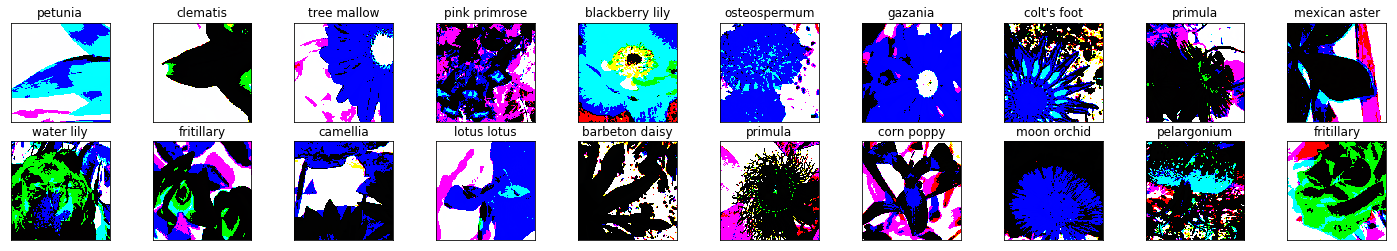

In [5]:

# Obtem um batch de imagens, que foi definido como 20 no primeiro passo.
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Converte imagens para exibir com numpy

# Imprimi as imagens no batch de imagens com a label correspondente.
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)).astype(np.uint8))
    ax.set_title(classes[labels[idx]])

## 4) Carregar uma rede reural pre treinada [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) e configurar o ouput conforme o dataset 


In [6]:
#Nesse caso foi utilizado a rede resnet18 por não ser muito pesada e por conseguir fornecer um bom resultado nesse caso.
redeNeural = models.resnet18(pretrained=True)

### Configuração extra para habilitar GPU caso o PC possua.

In [7]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
##Alterar a quantidade de ouput conforme o dataset escolhido, nesse caso 102
from collections import OrderedDict
import torch.nn as nn
n_inputs = redeNeural.fc.in_features   
last_layer = nn.Linear(n_inputs, len(classes))
redeNeural.fc = last_layer

## 5) Validar o % de acuracia do modelo pre treinado

In [9]:
#Antes de validar o modelo é preciso incluir o tipo de criterion e optimizer

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(redeNeural.fc.parameters(), lr=0.001)

In [10]:
if train_on_gpu:
    redeNeural.cuda()
test_loss = 0.0
size = len(classes);
class_correct = list(0. for i in range(size))
class_total = list(0. for i in range(size))

redeNeural.eval() # prep model for evaluation
test_losses = []

for batch_i, (data, target) in enumerate(valid_loader):
    # forward pass: compute predicted outputs by passing inputs to the model
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = redeNeural(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(pred.size()[0]):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except:
            print("Não foi encontrado o dataset de teste para a classe: ", classes[i])
            print("Não foi encontrado o dataset de teste para a classe: ", torch.max(output))
            print("Não foi encontrado o dataset de teste para a classe: ", torch.max(output,1))

redeNeural.train()
# calculate and print avg test loss
test_loss = test_loss/len(valid_loader.dataset)
test_losses.append(test_loss/len(valid_loader))
print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 4.779866


Test Accuracy (Overall):  2% (17/818)


In [11]:
## Método para reccaregar o modelo já treinado
def _reload_module():
    redeNeural.load_state_dict(torch.load('model-saved.pth'))
    redeNeural.cuda()

In [12]:
_reload_module()

## 6) Treinar o modelo e salvar o melhor resultado
Essa talvez seja a etapa mais importante do fluxo de treinamento do modelo.

In [32]:
# Epoch é algo semelhante a iteração no caso de ML(Machine Learning). 
# Quanto mais Epoch mais o modelo será treinado e terá um desempenho melhor. Mas é necessário tomar cuidado com Overfitting.
n_epochs = 15
globalLoss = 0.992168;
for epoch in range(1, n_epochs+1):

    # A perda de treino será incrementada a cada batch 
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for batch_i, (data, target) in enumerate(train_loader):

        ##Utilizar GPU caso esteja disponivel.
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = redeNeural(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            train_loss_mean = train_loss / 20;
            print('Epoch %d, Batch %d loss: %.16f' % (epoch, batch_i + 1, train_loss_mean))
            if  train_loss_mean <= globalLoss:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                globalLoss,
                train_loss_mean))
                torch.save(redeNeural.state_dict(), 'model-saved.pth')
                globalLoss = train_loss_mean
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.4030790209770203
Validation loss decreased (100.000000 --> 1.403079).  Saving model ...
Epoch 1, Batch 40 loss: 1.3979792892932892
Validation loss decreased (1.403079 --> 1.397979).  Saving model ...
Epoch 1, Batch 60 loss: 1.4837200522422791
Epoch 1, Batch 80 loss: 1.4290707617998124
Epoch 1, Batch 100 loss: 1.3933308184146882
Validation loss decreased (1.397979 --> 1.393331).  Saving model ...
Epoch 1, Batch 120 loss: 1.4482268542051315
Epoch 1, Batch 140 loss: 1.3614971011877059
Validation loss decreased (1.393331 --> 1.361497).  Saving model ...
Epoch 1, Batch 160 loss: 1.5189761459827422
Epoch 1, Batch 180 loss: 1.5789828777313233
Epoch 1, Batch 200 loss: 1.4006938993930818
Epoch 1, Batch 220 loss: 1.4222101956605910
Epoch 1, Batch 240 loss: 1.4946304261684418
Epoch 1, Batch 260 loss: 1.3181704461574555
Validation loss decreased (1.361497 --> 1.318170).  Saving model ...
Epoch 1, Batch 280 loss: 1.5156518578529359
Epoch 1, Batch 300 loss: 1.39349592328071

Epoch 11, Batch 60 loss: 1.2326551347970962
Epoch 11, Batch 80 loss: 1.1800047785043717
Epoch 11, Batch 100 loss: 1.2390828341245652
Epoch 11, Batch 120 loss: 1.2841695576906205
Epoch 11, Batch 140 loss: 1.1446160316467284
Epoch 11, Batch 160 loss: 1.1375470548868178
Epoch 11, Batch 180 loss: 1.2523590594530105
Epoch 11, Batch 200 loss: 1.2203792989253999
Epoch 11, Batch 220 loss: 1.1863301128149033
Epoch 11, Batch 240 loss: 1.0858822226524354
Validation loss decreased (1.127196 --> 1.085882).  Saving model ...
Epoch 11, Batch 260 loss: 1.2675704270601273
Epoch 11, Batch 280 loss: 1.3159529507160186
Epoch 11, Batch 300 loss: 1.1687407046556473
Epoch 11, Batch 320 loss: 1.2256975322961807
Epoch 12, Batch 20 loss: 1.1965543806552887
Epoch 12, Batch 40 loss: 1.1582913190126418
Epoch 12, Batch 60 loss: 1.2291483849287033
Epoch 12, Batch 80 loss: 1.1166010946035385
Epoch 12, Batch 100 loss: 1.2384308576583862
Epoch 12, Batch 120 loss: 1.1508761018514633
Epoch 12, Batch 140 loss: 1.126029735

## 7) Carregar o modelo e validar o % de acuracia

In [33]:
# Reccarega o modelo treinado.
_reload_module()
test_loss = 0.0
size = len(classes);

class_correct = list(0. for i in range(size))
class_total = list(0. for i in range(size))

redeNeural.eval() # prep model for evaluation
test_losses = []

for batch_i, (data, target) in enumerate(valid_loader):
    # forward pass: compute predicted outputs by passing inputs to the model
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = redeNeural(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except:
            print(target.size())
            print("Não foi encontrado o dataset de teste para a classe: ", classes[i])

redeNeural.train()
# calculate and print avg test loss
test_loss = test_loss/len(valid_loader.dataset)
test_losses.append(test_loss/len(valid_loader))
print('Test Loss: {:.6f}\n'.format(test_loss))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

torch.Size([18])
Não foi encontrado o dataset de teste para a classe:  ball moss
torch.Size([18])
Não foi encontrado o dataset de teste para a classe:  love in the mist
Test Loss: 1.199480


Test Accuracy (Overall): 79% (650/818)


## 8) Exibir a probabilidade do modelo acertar a imagem em um subconjunto de imagens.

Acertos:  17


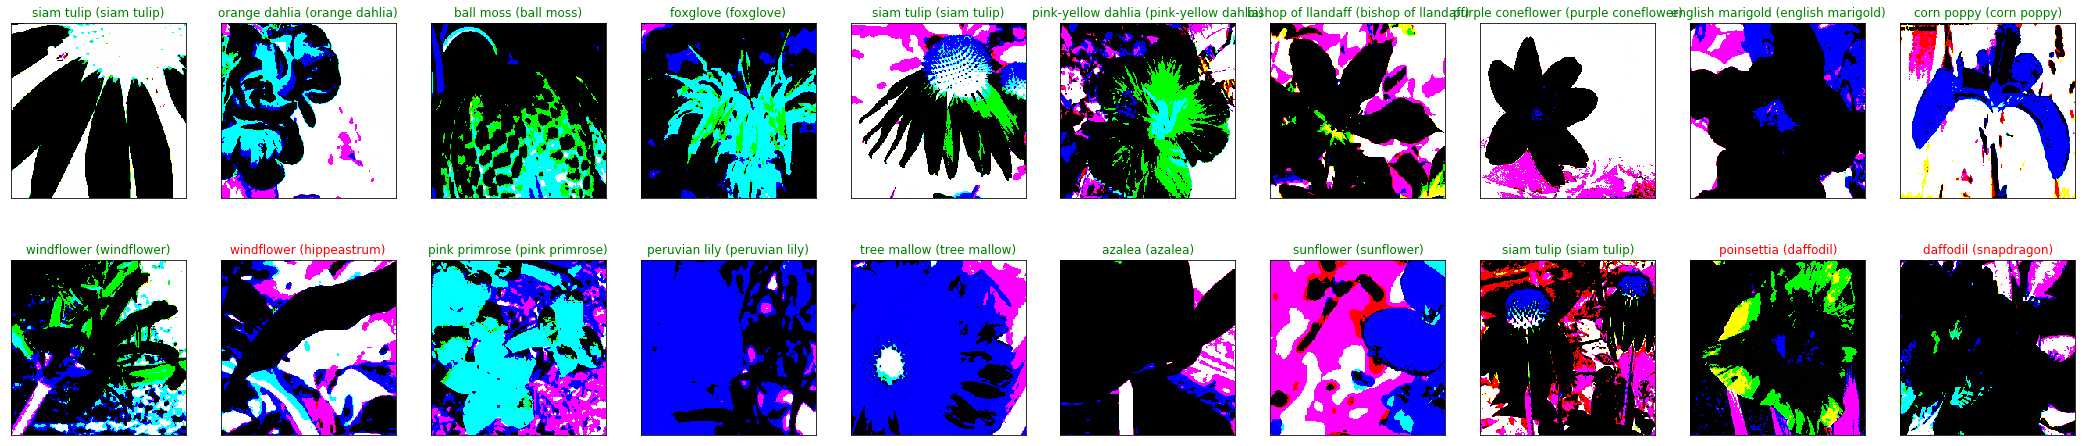

In [39]:
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = dataiter.next()


# move model inputs to cuda, if GPU available
if train_on_gpu:
    imagesCuda = images.cuda()
    redeNeural.cuda()
output = redeNeural(imagesCuda)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

images = images.numpy()

# plot the images in the batch, along with predicted and true labels
count = 0
fig = plt.figure(figsize=(37, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)).astype(np.uint8))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
    if preds[idx].item()==labels[idx].item():
        count +=1
print("Acertos: ", count)

## Construir o arquivo de submissão no Kaggle
Esse projeto teve como score = 0.78484

In [35]:
# The prediction of our model is an index which we need to convert back to the class label.
# For this, we will use the following mapping
idx_to_class = {val: key for key, val in valid_dataset.class_to_idx.items()}
print(idx_to_class)

{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 101:

In [36]:
def predict(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    model.eval()
    
    predictions = {}   
    with torch.no_grad():
        for ii, (images, _, img_names) in enumerate(test_loader, start=1):
            if ii % 5 == 0:
                print('Batch {}/{}'.format(ii, len(test_loader)))
            images = images.to(device)
            logps = model(images)
            ps = torch.exp(logps)
            
            # Top indices
            _, top_indices = ps.topk(1)
            top_indices = top_indices.detach().cpu().numpy().tolist()
    
            # Convert indices to classes
            top_classes = [idx_to_class[idx[0]] for idx in top_indices]
            
            for i, img_name in enumerate(img_names):
                predictions[img_name] = top_classes[i]
            
        print('\nCompleted')

    return predictions


In [37]:
predictions = predict(redeNeural, test_loader)

cuda
Batch 5/41
Batch 10/41
Batch 15/41
Batch 20/41
Batch 25/41
Batch 30/41
Batch 35/41
Batch 40/41

Completed


In [38]:
submission = pd.DataFrame(list(predictions.items()), columns=['file_name', 'id'])
submission.to_csv('submission.csv', index=False)
print(submission)

           file_name   id
0    image_00005.jpg   77
1    image_00006.jpg   77
2    image_00024.jpg   77
3    image_00025.jpg   77
4    image_00029.jpg   77
5    image_00050.jpg   77
6    image_00060.jpg   77
7    image_00065.jpg   77
8    image_00092.jpg   77
9    image_00099.jpg   77
10   image_00114.jpg   77
11   image_00116.jpg   77
12   image_00132.jpg   77
13   image_00176.jpg   77
14   image_00177.jpg   77
15   image_00187.jpg   77
16   image_00191.jpg   77
17   image_00202.jpg   77
18   image_00203.jpg   77
19   image_00204.jpg   77
20   image_00212.jpg   77
21   image_00222.jpg   77
22   image_00239.jpg   77
23   image_00248.jpg   77
24   image_00251.jpg   77
25   image_00258.jpg   73
26   image_00260.jpg   73
27   image_00277.jpg   73
28   image_00282.jpg   73
29   image_00284.jpg   73
..               ...  ...
789  image_07902.jpg  100
790  image_07926.jpg   17
791  image_07936.jpg  100
792  image_07938.jpg   46
793  image_07939.jpg  100
794  image_07949.jpg   89
795  image_0